In [1]:
from lagrangian_case import TrajectoryCase, AircraftCase, all_cases
import matplotlib.pyplot as plt
from matplotlib import gridspec, rc
import os
import utils
import xarray as xr
import met_utils as mu
import numpy as np
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as mdates



# font = {'family' : 'DejaVu Sans',
#         'weight' : 'bold',
#         'size'   : 16}
# rc('font', **font)


# %matplotlib ipympl
%load_ext autoreload
%autoreload 2

In [2]:
TLC06 = TrajectoryCase(all_cases[6]['TLC_name'])
TLC06.add_traj_data()
TLC10 = TrajectoryCase(all_cases[10]['TLC_name'])
TLC10.add_traj_data()
ALC06 = AircraftCase(all_cases[6]['ALC_name'])
ALC10 = AircraftCase(all_cases[10]['ALC_name'])

adding ERA ens w_vert
adding ERA ens w_vert
adding ERA ens w_vert
adding ERA ens w_vert
adding ERA ens w_vert
adding ERA ens w_vert
adding ERA ens w_vert


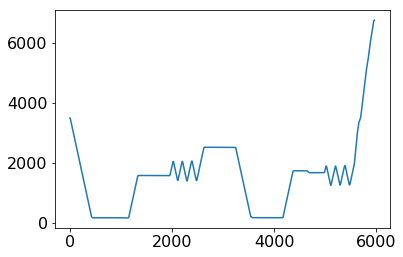

In [3]:
data = ALC10.return_flight_data
plt.plot(data.GGALT)
# plt.plot(data.PSXC)
# data.ERA_z.sel(level=1000)/9.81
# if 'ERA_ens_w' in data.data_vars.keys():
#     print('adding ERA ens w_vert')
#     w_pres_ens = data.ERA_ens_w.values
#     rho_ens = mu.density_from_p_Tv(np.broadcast_to(data.level.values, w_pres_ens.shape)*100, Tv=data.ERA_t.values)  # TODO get virtual temp right
#     w_vert = -w_pres/(rho*9.81)
#     data['ERA_w_vert'] = (('time', 'level'), np.array(w_vert))
#     data['ERA_w_vert'] = data['ERA_w_vert'].assign_attrs({"long_name": "vertical_velocity", "units": "m/s"})
#     data['ERA_rho'] = (('time', 'level'), np.array(rho))
#     data['ERA_rho'] = data['ERA_rho'].assign_attrs({"long_name": "air density", "units": "kg/m3"})
            

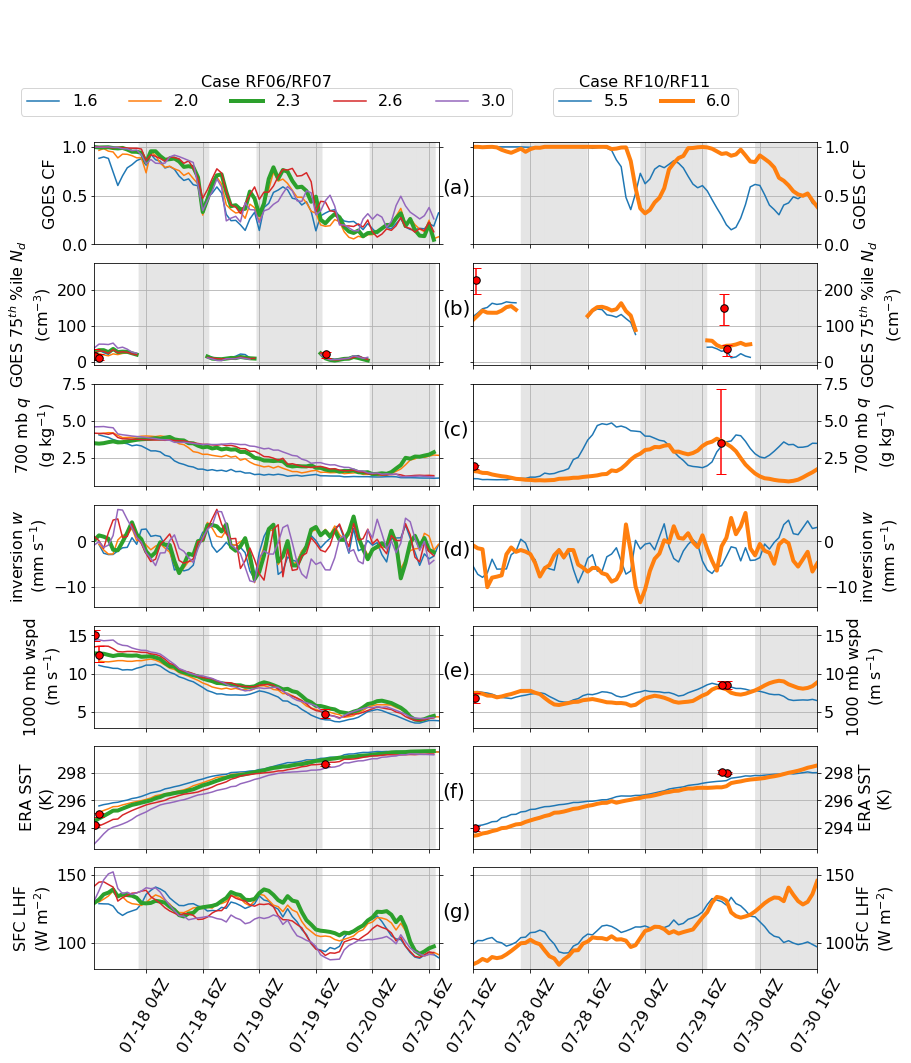

In [4]:
def add_daynight_to_plot(TLC, ax):
    nans = []
    dates = []
    for f in TLC.goes_files.values():
        with xr.open_dataset(f) as data:
            nans.append(np.isnan((data.visible_count.values.mean(axis=(1,2)))))
            dates.append(data.time.values)
    daynight = np.tile(np.any(np.array(nans, dtype=int), axis=0), (2,1))
    times = np.mean(np.array(dates, dtype='int64'), axis=0).astype('datetime64[ns]')
    ys = ax.get_ylim()
    ax.pcolor(times, ys, daynight, cmap='Greys', alpha=0.1, edgecolor=(1,1,1,0.8), linewidth=0.001, zorder=0)
    ax.grid(True)

    
def add_TLC_var_to_plot(TLC, ax, dtype, varname, level=None, level2=None, name=None, mult=1, **kwargs):
    if dtype == 'traj' and level is None and level2 is None:
        data = {k: x[varname] for k, x in TLC.traj_data.items()}
#         data = [x[varname] for x in TLC.traj_data.values()]
    elif dtype =='traj_lev' and level=='inv':
        data = TLC.get_from_inv(varname)
    else:
        data = TLC.get_variable(dtype, varname, level, level2)    
    if name is None:
        name = varname
    for (trajname, d) in sorted(data.items()):
        if trajname in ['2.3', '6.0']:
            p = ax.plot(d.time, d.values*mult, lw=4, **kwargs)
        else: 
            p = ax.plot(d.time, d.values*mult, **kwargs)
        ax.set_ylabel(name + "\n({})".format(d.attrs.setdefault('units', 'unitless')))
        ax.grid(True)
        
def add_ALC_var_to_plot(ALC, ax, varname, name, legname, cloud_only=False, add=0, avgmethod='median', **kwargs):
    for fp in ALC.outbound_Flight_Piece, ALC.return_Flight_Piece:
        data = fp.get_variable_by_leg(varname, legname, cloud_only)
        for seq in set(data.sequence.values):
            data2 = data.where(data.sequence==seq, drop=True)+add
            time = utils.as_datetime(data2.time[int(len(data2)/2)].values)
            if avgmethod == 'median':
                d = np.nanmedian(data2)
                d_upper = np.nanpercentile(data2, 75)-d
                d_lower = d-np.nanpercentile(data2, 25)
#                 print(varname, d, d_upper, d_lower)
                p = ax.errorbar(x=time, y=d, yerr=np.array([[d_lower, d_upper]]).T, marker='.', capsize=5, **kwargs)
            elif avgmethod =='mean':
                d = np.nanmean(data2)                           
                d_std = np.nanstd(data2)
                p = ax.errorbar(x=time, y=d, yerr=d_std, marker='.', capsize=4, **kwargs)
            else: 
                raise ValueError("unknown averaging method")
            
def add_ALC_var_to_plot_by_pres(ALC, ax, varname, pres1, pres2, mult=1, **kwargs):
    for data in ALC.outbound_flight_data, ALC.return_flight_data:
        data2 = data[varname].where(np.logical_and(data['PSXC'] > pres1, data['PSXC'] < pres2), drop=True)*mult
        if len(data2)==0:
            return
        time = utils.as_datetime(data2.time[int(len(data2)/2)].values)
        d = np.nanmedian(data2)
        d_upper = np.nanpercentile(data2, 75)-d
        d_lower = d-np.nanpercentile(data2, 25)
#         print(d, d_upper, d_lower)
        p = ax.errorbar(x=time, y=d, yerr=np.array([[d_lower, d_upper]]).T, marker='.', capsize=5, **kwargs)


        
#             ax.errorbar(x=traj_data.time.values, y=traj_data.MODIS_CTH*1000, yerr=traj_data.MODIS_CTH_std*1000, 
#              marker='.', ms=20, ls='', lw=2, capsize=4, label='MODIS cloud top')
        
        
        
fig, ax = plt.subplots(figsize=(12,14), nrows=8, ncols=2, gridspec_kw={"height_ratios": [0.3, 1, 1 ,1, 1, 1, 1, 1]}, sharex='col', sharey='row')

ax[0,0].set_title("Case RF06/RF07")
ax[0,0].axis('off')
add_TLC_var_to_plot(TLC06, ax[0,0], dtype='goes', varname='warm_low_cloud_fraction')
lines = ax[0,0].lines
ax[0,0].legend(lines, TLC06.trajectories, ncol=len(lines), loc='lower center')
[i.set_linestyle('None') for i in lines]

ax[0,1].set_title("Case RF10/RF11")
ax[0,1].axis('off')
add_TLC_var_to_plot(TLC10, ax[0,1], dtype='goes', varname='warm_low_cloud_fraction')
lines = ax[0,1].lines
ax[0,1].legend(lines, TLC10.trajectories, ncol=len(lines), loc='lower center')
[i.set_linestyle('None') for i in lines]

plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.1)
        
#1 CF
add_TLC_var_to_plot(TLC06, ax[1,0], dtype='goes', varname='warm_low_cloud_fraction', name='GOES CF')
add_TLC_var_to_plot(TLC10, ax[1,1], dtype='goes', varname='warm_low_cloud_fraction', name='GOES CF')
for axi in ax[1,:]:
    axi.set_ylabel('GOES CF')

#2 Nd
add_TLC_var_to_plot(TLC06, ax[2,0], dtype='goes', varname='Nd_75th_percentile', name='GOES 75th %ile Nd')
add_ALC_var_to_plot(ALC06, ax[2,0], varname='CONCD_LWOI', name='AC Nd', legname='c', cloud_only=True, avgmethod='median', ms=15, c='r', mec='k')
add_TLC_var_to_plot(TLC10, ax[2,1], dtype='goes', varname='Nd_75th_percentile', name='GOES 75th %ile Nd')
add_ALC_var_to_plot(ALC10, ax[2,1], varname='CONCD_LWOI', name='AC Nd', legname='c', cloud_only=True, avgmethod='median', ms=15, c='r', mec='k')
for axi in ax[2,:]:
    axi.set_ylabel('GOES 75$^{th}$ %ile $N_d$\n(cm$^{-3}$)')

#3 700mb moisture
add_TLC_var_to_plot(TLC06, ax[3,0], dtype='traj_lev', level=700, varname='ERA_q', name='700mb q', mult=1000)
add_ALC_var_to_plot_by_pres(ALC06, ax[3,0], varname='MR', pres1=675, pres2=725, mult=1, ms=15, c='r', mec='k')
add_TLC_var_to_plot(TLC10, ax[3,1], dtype='traj_lev', level=700, varname='ERA_q', name='700mb q', mult=1000)                
add_ALC_var_to_plot_by_pres(ALC10, ax[3,1], varname='MR', pres1=675, pres2=725, mult=1, ms=15, c='r', mec='k')
for axi in ax[3,:]:
    axi.set_ylabel('700 mb $q$\n(g kg$^{-1}$)')

# #4 850m vertical velocity
# add_TLC_var_to_plot(TLC06, ax[4,0], dtype='traj_lev', level=850, varname='ERA_w_vert', name='850mb w', mult=1000)
# add_TLC_var_to_plot(TLC10, ax[4,1], dtype='traj_lev', level=850, varname='ERA_w_vert', name='850mb w', mult=1000)      
# for axi in ax[4,:]:
#     axi.set_ylabel('850mb w \n(mm/s)')

#4 inversion vertical velocity
add_TLC_var_to_plot(TLC06, ax[4,0], dtype='traj_lev', level='inv', varname='ERA_w_vert', name='inversion w', mult=1000)
add_TLC_var_to_plot(TLC10, ax[4,1], dtype='traj_lev', level='inv', varname='ERA_w_vert', name='inversion w', mult=1000)      
for axi in ax[4,:]:
    axi.set_ylabel('inversion $w$\n(mm s$^{-1}$)')

#5 150m windspeed
add_TLC_var_to_plot(TLC06, ax[5,0], dtype='traj_lev', level=1000, varname='ERA_wspd', name='1000mb wpsd')
add_ALC_var_to_plot(ALC06, ax[5,0], varname='WSC', name='AC wspd', legname='b', cloud_only=False, avgmethod='median', ms=15, c='r', mec='k')
add_TLC_var_to_plot(TLC10, ax[5,1], dtype='traj_lev', level=1000, varname='ERA_wspd', name='1000mb wpsd')
add_ALC_var_to_plot(ALC10, ax[5,1], varname='WSC', name='AC wspd', legname='b', cloud_only=False, avgmethod='median', ms=15, c='r', mec='k')
for axi in ax[5,:]:
    axi.set_ylabel('1000 mb wspd\n(m s$^{-1}$)')

#6 SST
add_TLC_var_to_plot(TLC06, ax[6,0], dtype='traj', varname='ERA_sst', name='ERA SST')
add_ALC_var_to_plot(ALC06, ax[6,0], varname='RSTB', name='AC SST', legname='b', cloud_only=False, add=273.15, avgmethod='median', ms=15, c='r', mec='k')
add_TLC_var_to_plot(TLC10, ax[6,1], dtype='traj', varname='ERA_sst', name='ERA SST')
add_ALC_var_to_plot(ALC10, ax[6,1], varname='RSTB', name='AC SST', legname='b', cloud_only=False, add=273.15, avgmethod='median', ms=15, c='r', mec='k')
for axi in ax[6,:]:
    axi.set_yticks([294, 296, 298])
    axi.set_ylabel('ERA SST\n(K)')

#7 LHF TODO REMOVE
add_TLC_var_to_plot(TLC06, ax[7,0], dtype='traj', varname='ERA_ie', mult=-2.4625*1e6)
add_TLC_var_to_plot(TLC10, ax[7,1], dtype='traj', varname='ERA_ie', mult=-2.4625*1e6)
for axi in ax[7,:]:
    axi.set_ylabel('SFC LHF\n(W m$^{-2}$)')

# ax[6,0].yaxis.set_major_formatter(FormatStrFormatter('%.0e'))
# ax[6,1].yaxis.set_major_formatter(FormatStrFormatter('%.0e'))


rf06_axes = ax[1:,0]
rf10_axes = ax[1:,1]
for TLC, axlist in zip([TLC06, TLC10], [rf06_axes, rf10_axes]):
    for axi in axlist:
        add_daynight_to_plot(TLC, axi)
        axi.yaxis.set_ticks_position("both")
        axi.tick_params(axis='y', left=True, right=True, labelleft=True, labelright=False)
        plt.setp(axi.get_xticklabels(), rotation=60)
for axi in rf10_axes:
    axi.yaxis.set_label_position("right")
    axi.tick_params(axis='y', left=True, right=True, labelleft=False, labelright=True)

myFmt = mdates.DateFormatter('%m-%d %HZ')
for axi in ax.flatten():
    axi.xaxis.set_major_formatter(myFmt)

for i, lab in enumerate('abcdefg'):
    axi = ax[i+1,1]
    axi.text(-.09, 0.5, "({})".format(lab), horizontalalignment='left', transform=axi.transAxes, fontdict = {'size': 20})

fig.savefig(os.path.join(utils.plot_dir, '8_all_trajectory_data.png'), dpi=300, bbox_inches='tight')


In [293]:
TLC06.get_from_inv('ERA_w_vert')

{'1.6': <xarray.DataArray 'ERA_w_vert' (time: 73)>
 array([ 1.510190e-03,  1.206665e-03,  1.112028e-03,  1.040761e-03,
         1.351303e-03,  2.005082e-03,  1.025825e-03,  3.100011e-03,
         1.704664e-03,  2.300383e-03,  1.611617e-03,  1.579750e-04,
         1.694786e-03,  4.410171e-04, -6.483809e-04,  1.009487e-03,
        -3.401427e-03, -1.109722e-04, -4.076444e-03, -1.813276e-03,
        -3.461230e-03,  8.811292e-04,  7.420700e-04,  2.222055e-03,
        -1.140012e-03, -2.871118e-04,  9.850010e-05,  1.149107e-03,
         9.951113e-04,  2.313898e-03, -1.177228e-04, -1.320040e-03,
        -4.944953e-03, -6.916883e-03, -2.286677e-03, -2.597938e-04,
         1.471936e-03,  1.499241e-03,  1.026972e-03,  1.335316e-03,
        -3.316344e-03, -1.855119e-03, -8.049767e-04, -5.412807e-04,
        -2.523722e-03, -2.306143e-03, -2.779550e-03, -6.830063e-03,
        -5.340408e-03, -5.353602e-03, -2.806676e-03, -1.494007e-03,
         1.793128e-03,  2.317789e-03,  3.936313e-03, -1.671084e-0

In [292]:
x

{'1.6': array([ 1.51018955e-03,  1.20666458e-03,  1.11202752e-03,  1.04076118e-03,
         1.35130303e-03,  2.00508215e-03,  1.02582547e-03,  3.10001117e-03,
         1.70466406e-03,  2.30038322e-03,  1.61161669e-03,  1.57974971e-04,
         1.69478606e-03,  4.41017092e-04, -6.48380876e-04,  1.00948657e-03,
        -3.40142673e-03, -1.10972213e-04, -4.07644396e-03, -1.81327586e-03,
        -3.46122964e-03,  8.81129208e-04,  7.42069975e-04,  2.22205498e-03,
        -1.14001169e-03, -2.87111777e-04,  9.85000982e-05,  1.14910727e-03,
         9.95111278e-04,  2.31389797e-03, -1.17722790e-04, -1.32004030e-03,
        -4.94495326e-03, -6.91688282e-03, -2.28667682e-03, -2.59793757e-04,
         1.47193588e-03,  1.49924102e-03,  1.02697194e-03,  1.33531593e-03,
        -3.31634355e-03, -1.85511942e-03, -8.04976746e-04, -5.41280743e-04,
        -2.52372164e-03, -2.30614336e-03, -2.77954958e-03, -6.83006321e-03,
        -5.34040824e-03, -5.35360246e-03, -2.80667619e-03, -1.49400698e-03,
     